In [1]:
import pandas as pd
from textblob import TextBlob
import os

In [3]:
# Load News Dataset
news_df = pd.read_csv("../data/raw_analyst_ratings.csv", parse_dates=["date"])
news_df['date'] = pd.to_datetime(
    news_df['date'], format='mixed', errors='coerce', utc=True)
news_df['date'] = news_df['date'].dt.date
news_df.dropna(subset=["headline"], inplace=True)
print(news_df.head())

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  
3  2020-05-22     A  
4  2020-05-22     A  


In [4]:
# Sentiment Analysis using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity


news_df["sentiment"] = news_df["headline"].apply(get_sentiment)

In [5]:
print(news_df.head())

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  sentiment  
0  2020-06-05     A        0.0  
1  2020-06-03     A        0.0  
2  2020-05-26     A        0.0  
3  2020-

In [8]:
# Aggregate average sentiment by date
daily_sentiment = news_df.groupby("date")["sentiment"].mean().reset_index()
daily_sentiment.columns = ["date", "avg_sentiment"]

In [9]:
# List of stock CSVs and tickers
ticker_files = {
    "AAPL": "../data/AAPL_historical_data.csv",
    "AMZN": "../data/AMZN_historical_data.csv",
    "GOOG": "../data/GOOG_historical_data.csv",
    "META": "../data/META_historical_data.csv",
    "MSFT": "../data/MSFT_historical_data.csv",
    "NVDA": "../data/NVDA_historical_data.csv",
    "TSLA": "../data/TSLA_historical_data.csv"
}

In [10]:
# Output directory
os.makedirs("outputs/task3/", exist_ok=True)

In [11]:
# Loop through tickers and compute correlation
results = []

for ticker, file in ticker_files.items():
    print(f"🔍 Processing {ticker}...")

    stock_df = pd.read_csv(file, parse_dates=["Date"])
    stock_df["date"] = stock_df["Date"].dt.date
    stock_df.sort_values("date", inplace=True)
    stock_df["daily_return"] = stock_df["Close"].pct_change()

    # Merge with sentiment data
    merged = pd.merge(daily_sentiment, stock_df[[
                      "date", "daily_return"]], on="date", how="inner").dropna()

    if not merged.empty:
        corr = merged["avg_sentiment"].corr(
            merged["daily_return"], method="pearson")
        results.append({
            "Ticker": ticker,
            "Correlation": corr,
            "Num_Merged_Records": len(merged)
        })

        # Save the merged dataframe
        merged.to_csv(
            f"outputs/task3/{ticker}_sentiment_correlation_data.csv", index=False)

🔍 Processing AAPL...
🔍 Processing AMZN...
🔍 Processing GOOG...
🔍 Processing META...
🔍 Processing MSFT...
🔍 Processing NVDA...
🔍 Processing TSLA...


In [12]:
# Save summary
summary_df = pd.DataFrame(results)
summary_df.to_csv(
    "outputs/task3/sentiment_return_correlation_summary.csv", index=False)

print("\n✅ Task 3 Complete. Results saved in 'outputs/task3/' folder.")
print(summary_df)


✅ Task 3 Complete. Results saved in 'outputs/task3/' folder.
  Ticker  Correlation  Num_Merged_Records
0   AAPL     0.045453                2757
1   AMZN     0.005832                2757
2   GOOG     0.017346                2757
3   META     0.087696                1886
4   MSFT     0.032802                2757
5   NVDA    -0.026393                2757
6   TSLA     0.049787                2505


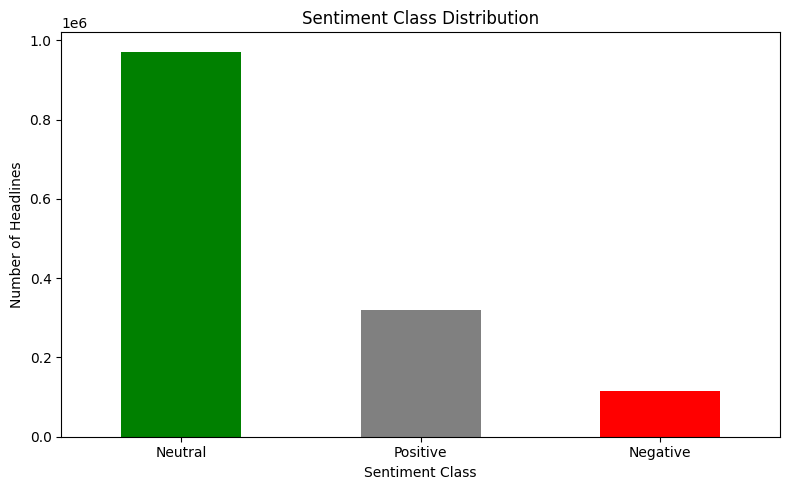

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# Load your dataset
news_df = pd.read_csv("../data/raw_analyst_ratings.csv")

# Drop rows with missing headlines and parse date
news_df.dropna(subset=["headline"], inplace=True)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Sentiment classification


def classify_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"


news_df["sentiment_class"] = news_df["headline"].apply(classify_sentiment)

# Plot
plt.figure(figsize=(8, 5))
news_df["sentiment_class"].value_counts().plot(
    kind="bar", color=["green", "grey", "red"]
)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Headlines")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/task3/sentiment_class_distribution.png")
plt.show()